In [158]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow.keras import layers
import random
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import itertools

In [30]:
rootDir = './animals-dataset'
trainingDir = rootDir + '/training'
testDir = rootDir + '/test'

In [31]:
seed = 512
validation_split = 0.2
interpolation = "bilinear"
batch_size = 32
img_height = 256
img_width = 256

In [18]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    trainingDir,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    interpolation=interpolation
)

Found 5000 files belonging to 10 classes.
Using 4000 files for training.


In [19]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    trainingDir,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    interpolation=interpolation
)

Found 5000 files belonging to 10 classes.
Using 1000 files for validation.


In [32]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    testDir,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    interpolation=interpolation
)

Found 1000 files belonging to 10 classes.


In [20]:
class_names = train_ds.class_names
print(class_names)

['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elefant', 'horse', 'sheep', 'spider', 'squirrel']


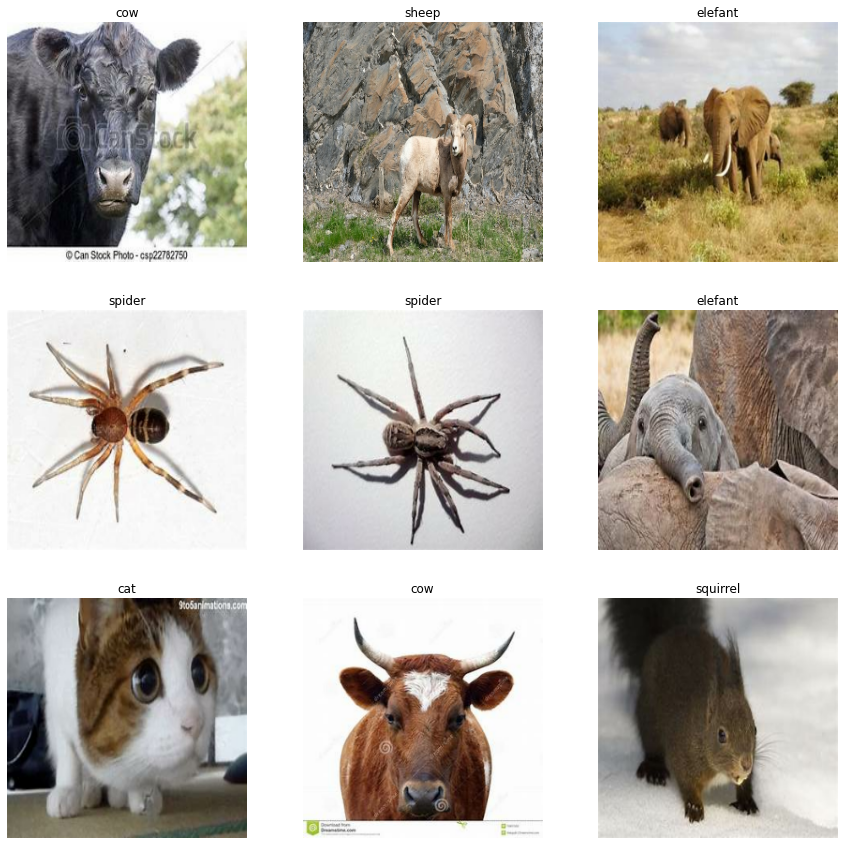

In [21]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [187]:
num_classes = 10
    
model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, 2, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 2, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [172]:
model.compile(
  optimizer=tf.optimizers.Adam(learning_rate=0.001),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [173]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
125/125 [==============================] - 74s 594ms/step - loss: 2.4658 - accuracy: 0.2227 - val_loss: 1.9256 - val_accuracy: 0.3310
Epoch 2/10
125/125 [==============================] - 78s 627ms/step - loss: 1.5745 - accuracy: 0.4683 - val_loss: 1.8094 - val_accuracy: 0.3920
Epoch 3/10
125/125 [==============================] - 76s 612ms/step - loss: 0.9925 - accuracy: 0.6933 - val_loss: 2.0351 - val_accuracy: 0.4030
Epoch 4/10
125/125 [==============================] - 74s 591ms/step - loss: 0.5659 - accuracy: 0.8428 - val_loss: 1.8769 - val_accuracy: 0.4510
Epoch 5/10
125/125 [==============================] - 75s 598ms/step - loss: 0.3188 - accuracy: 0.9158 - val_loss: 2.3275 - val_accuracy: 0.4150
Epoch 6/10
125/125 [==============================] - 75s 599ms/step - loss: 0.1517 - accuracy: 0.9665 - val_loss: 2.5175 - val_accuracy: 0.4020
Epoch 7/10
125/125 [==============================] - 73s 586ms/step - loss: 0.0825 - accuracy: 0.9850 - val_loss: 3.2243 - val_ac

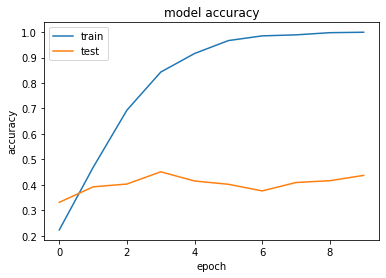

In [175]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

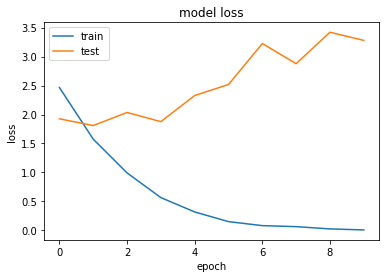

In [176]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [177]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)

32/32 [==============================] - 7s 215ms/step - loss: 2.9277 - accuracy: 0.4690


In [178]:
print('Test accuracy: ' +  str(test_acc) + " Loss: " + str(test_loss))

Test accuracy: 0.4690000116825104 Loss: 2.9276793003082275


In [179]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_ds)

In [180]:
predictions[0]

array([2.3613518e-04, 4.6505487e-05, 2.8520071e-09, 9.0377341e-12,
       4.8093398e-06, 1.4468906e-09, 1.0359675e-08, 1.2891760e-09,
       9.9971253e-01, 2.4878826e-09], dtype=float32)

In [181]:
np.argmax(predictions[0])

8

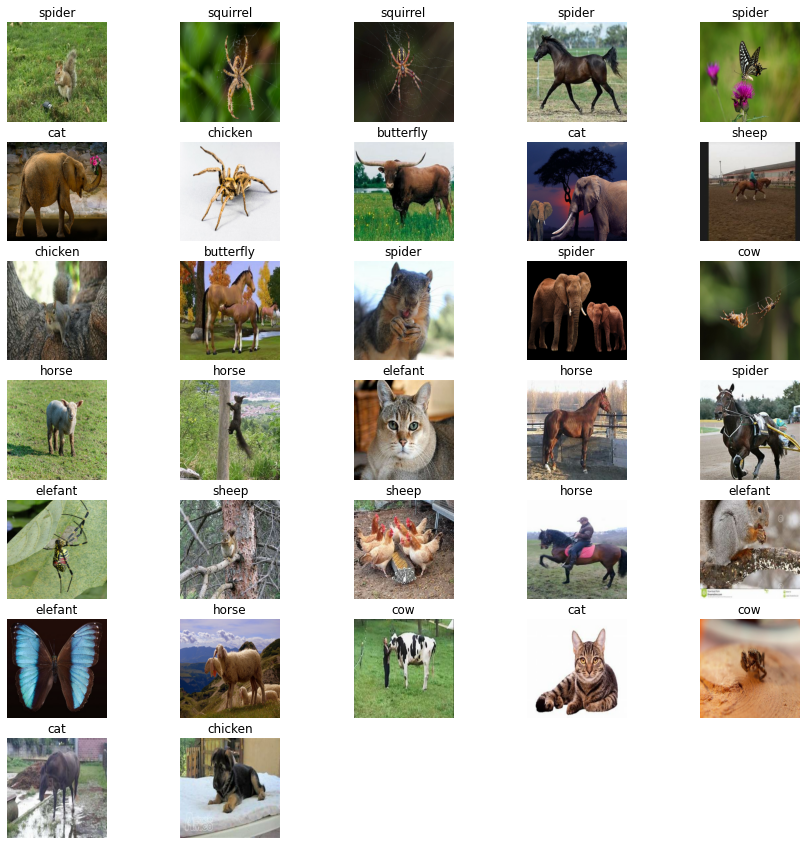

In [182]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(batch_size):
        ax = plt.subplot(7, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(predictions[i])])
        plt.axis("off")
#https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix

In [183]:
prediction_counter = 0
l = []
p = []
for images, labels in test_ds:
    for i in range(len(labels)):
        l.append(labels[i].numpy())
        p.append(np.argmax(predictions[prediction_counter]))
        prediction_counter += 1

In [184]:
cm = tf.math.confusion_matrix(l, p)
cm = cm / len(l)

In [185]:
# https://docs.python.org/3/library/itertools.html#module-itertools
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Use white text if squares are dark; otherwise black.
    threshold = np.max(cm) / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j].numpy(), horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #return figure

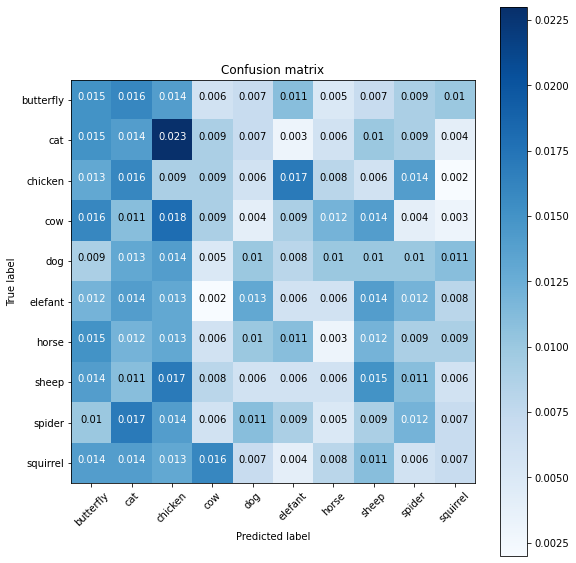

In [186]:
plot_confusion_matrix(cm, class_names)